In [33]:
import numpy as np
import pymc3 as pm 
import matplotlib.pyplot as plt
import theano.tensor as tt

X = np.linspace(-10, 10, 300)[:,None]  # i changed the 1000 to 300 to speed it up here

with pm.Model() as model:
    
    eta = 2.0
    lengthscale = 2.0
    base_cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)
    base_gp = pm.gp.Latent(cov_func=base_cov)
    
    log_wf = base_gp.prior("log_wf", X=X)
    wf = pm.Deterministic("wf", pm.math.exp(log_wf))
    
    def warp_gp_func(x, wf):
        return wf
    
    cov = pm.gp.cov.Gibbs(1, warp_gp_func, args=(wf,))
    
    K = pm.Deterministic("K", cov(X))
    
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X)

    mp = pm.find_MAP(include_transformed=True)
    
with model:
    tr = pm.sample(tune=1000, draws=100, cores=1)

<ipython-input-33-bba8930ff0e5>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr = pm.sample(tune=1000, draws=100, cores=1)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [f_rotated_, log_wf_rotated_]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 10 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


In [34]:
X_new = np.linspace(-1, 1, 1000)[:,None]

((100, 1), (100,))

In [56]:

X = np.linspace(-1, 1, 100)[:,None]
y = (X**3 - X**2 + X).reshape(100,)
X_new = np.linspace(-1, 1, 1000)[:,None]
print(X.shape, y.shape, X_new.shape)

with pm.Model() as model:

    eta_prior = pm.Gamma('eta_prior', alpha=2, beta=0.75)
    l_prior = pm.Gamma('l_prior', alpha=2, beta=0.75)
#     base_cov = eta_prior**2 * pm.gp.cov.ExpQuad(1, ls=l_prior)
#     base_gp = pm.gp.Latent(cov_func=base_cov) 
#     log_wf = base_gp.prior("log_wf", X=X)
#     wf = pm.Deterministic("wf", pm.math.exp(log_wf))

#     def warp_gp_func(x, wf):
#         return wf

#     cov = pm.gp.cov.Gibbs(1, warp_gp_func, args=(wf,))

#     K = pm.Deterministic("K", cov(X))

    cov_trend = eta_prior**2 * pm.gp.cov.ExpQuad(1, l_prior)
    gp = pm.gp.Marginal(cov_func=cov_trend)
    #Xu = pm.gp.util.kmeans_inducing_points(20, X)
    #f = gp.prior("f", X=X)

    #sigma = pm.Gamma('sigma', alpha=1, beta=2)
    #trace_prior = pm.sample(draws=500, return_inferencedata=False)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=0.01)

    #trace = pm.sample(draws=1000, tune=1000, chains=1)
    mp = pm.find_MAP(include_transformed=True)


(100, 1) (100,) (1000, 1)


In [57]:
# display the results, dont show transformed parameter values
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['eta_prior:4.838303877525545',
 'l_prior:1.1482791266132528',
 'σ:0.0031444292636167892']

In [58]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

In [37]:
# with model:
#      f_pred = gp.conditional("f_pred", X_new, point=mp, diag=True)
#      pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp

%matplotlib inline

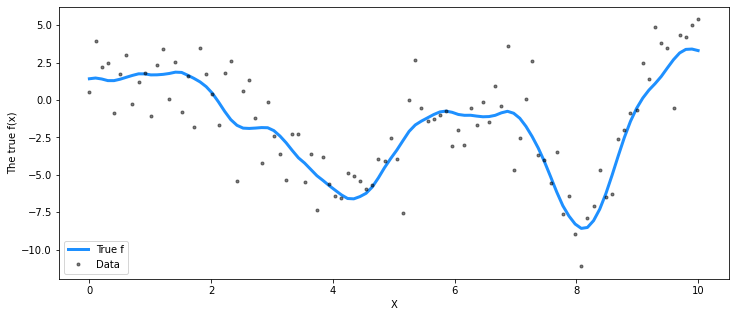

In [21]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [22]:
X.shape, y.shape

((100, 1), (100,))

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP()

In [5]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

In [6]:
X.shape, X_new.shape

((100, 1), (600, 1))

In [7]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=2000)

In [105]:
def tanh_func(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2.0 - (ls1 - ls2) / 2.0 * tt.tanh((x - x0) / w)


ls1 = 0.05
ls2 = 0.6
w = 0.3
x0 = 1.0
cov = pm.gp.cov.Gibbs(1, tanh_func, args=(ls1, ls2, w, x0))
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

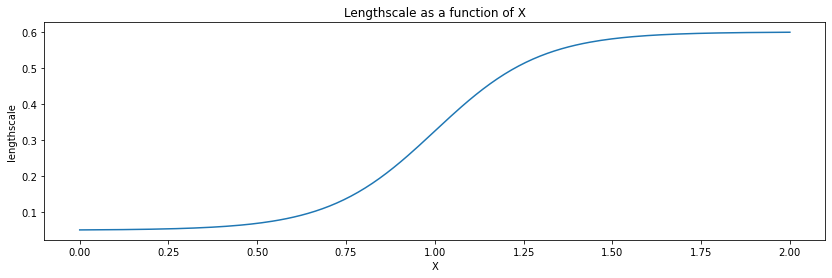

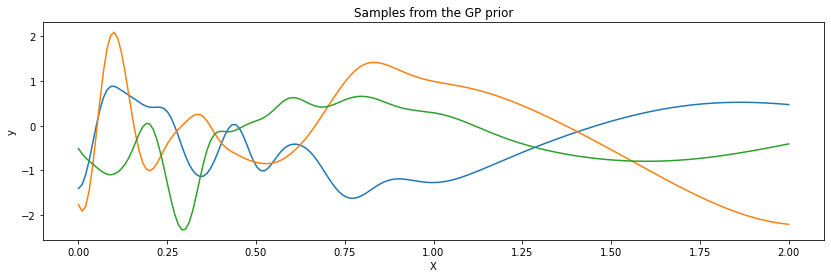

In [106]:
X = np.linspace(0, 2, 200)[:, None]
wf = tanh_func(X, ls1, ls2, w, x0).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, wf)
plt.ylabel("lengthscale")
plt.xlabel("X")
plt.title("Lengthscale as a function of X")

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");

In [181]:
np.array(X_tt.container.storage).squeeze().shape

(100,)

In [175]:
vars()

TypeError: vars() argument must have __dict__ attribute

In [33]:
X = np.linspace(-1, 1, 100)[:,None]
y = (X**3 - X**2 + X).squeeze()
X.shape, y.shape

((100, 1), (100,))

In [163]:
import theano.tensor as tt
import theano

In [200]:
import warnings

import theano.tensor as at
import numpy as np

from theano.tensor.nlinalg import eigh

import pymc3 as pm

from pymc3.gp.cov import Constant, Covariance
from pymc3.gp.mean import Zero
from pymc3.gp.util import (
    cholesky,
    conditioned_vars,
    solve_lower,
    solve_upper,
    stabilize,
)
from pymc3.math import cartesian, kron_diag, kron_dot, kron_solve_lower, kron_solve_upper

In [215]:
.shape

(100, 1)

In [227]:
def prior_trick(self, name, X, reparameterize=True, **kwargs):
    if isinstance(X, theano.tensor.Variable):
        X = X.container.storage[0]
    f = self._build_prior(name, X, reparameterize, **kwargs)
    self.X = X
    self.f = f
    return f  


In [228]:
import numpy as np
import pymc3 as pm


X = np.linspace(-1, 1, 100)[:,None]
y = (X**3 - X**2 + X).reshape(100,)
X_new = np.linspace(-1, 1, 1000)[:,None]
print(X.shape, y.shape, X_new.shape)

X_tt = theano.shared(X)

with pm.Model() as model:

    eta_prior = pm.Gamma('eta_prior', alpha=2, beta=0.75)
    l_prior = pm.Gamma('l_prior', alpha=2, beta=0.75)
    base_cov = eta_prior**2 * pm.gp.cov.ExpQuad(1, ls=l_prior)
    base_gp = pm.gp.Latent(cov_func=base_cov) 
    base_gp.prior = prior_trick
    log_wf = base_gp.prior(base_gp, "log_wf", X=X_tt)
    wf = pm.Deterministic("wf", pm.math.exp(log_wf))

    def warp_gp_func(x, wf):
        return  wf


    cov = pm.gp.cov.Gibbs(1, lengthscale_func=warp_gp_func, args=(wf,))

    K = pm.Deterministic("K", cov(X_tt))

    gp = pm.gp.Marginal(cov_func=cov)
    
    
    y_ = gp.marginal_likelihood("y", X=X_tt, y=y, noise=0.01)

    #trace = pm.sample(draws=100, tune=500, chains=1)
    mp = pm.find_MAP()

(100, 1) (100,) (1000, 1)


In [229]:
type(log_wf)

pymc3.model.DeterministicWrapper

In [230]:
X_tt.set_value(X_new)

with model:
    f_pred = gp.predict(X_tt, point=mp)
#     pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=100)

/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


ValueError: Input dimension mis-match. (input[0].shape[0] = 1000, input[1].shape[0] = 100)

In [161]:
with model:
    f_pred = gp.conditional("f_pred", X_new)
#     pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=100)

ValueError: Input dimension mis-match. (input[0].shape[1] = 1000, input[1].shape[1] = 100)

In [129]:
pred_samples['f_pred'].shape

(100, 1000)

In [147]:
X.shape

(400, 1)

/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/.dcm/lib/python3.9/site-packages/pymc3/gp/cov.py:92: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


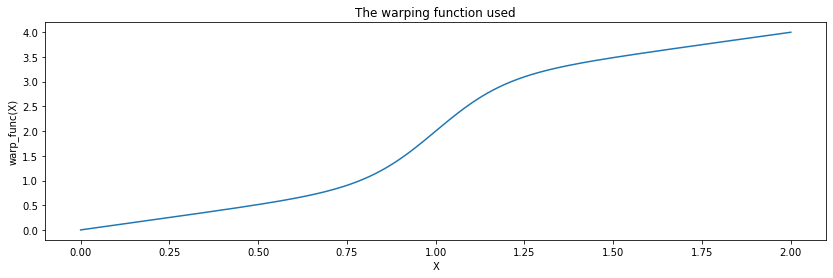

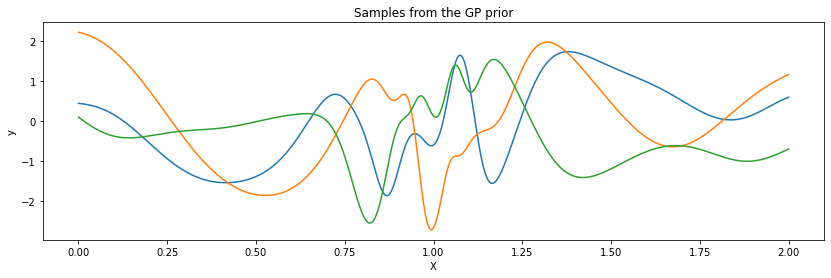

In [148]:
def warp_func(x, a, b, c):
    return 1.0 + x + (a * tt.tanh(b * (x - c)))


a = 1.0
b = 5.0
c = 1.0

cov_exp = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a, b, c), cov_func=cov_exp)
# Add white noise to stabilise
cov += pm.gp.cov.WhiteNoise(1e-6)

X = np.linspace(0, 2, 400)[:, None]
wf = warp_func(X.flatten(), a, b, c).eval()

plt.figure(figsize=(14, 4))
plt.plot(X, wf)
plt.xlabel("X")
plt.ylabel("warp_func(X)")
plt.title("The warping function used")

K = cov(X).eval()
plt.figure(figsize=(14, 4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(len(K)), cov=K, shape=len(K)).random(size=3).T)
plt.title("Samples from the GP prior")
plt.ylabel("y")
plt.xlabel("X");